In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import keras
import pandas as pd
import librosa
import numpy as np
import os
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("/kaggle/input/airs-ai-in-respiratory-sounds/train.csv")
train = train[train['candidateID'] != '5ee582f2832c2']
print(train.info())
print(train.isnull().sum())
train

<class 'pandas.core.frame.DataFrame'>
Index: 545 entries, 0 to 545
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   candidateID          545 non-null    object 
 1   age                  545 non-null    int64  
 2   gender               545 non-null    int64  
 3   tbContactHistory     545 non-null    float64
 4   wheezingHistory      545 non-null    float64
 5   phlegmCough          545 non-null    float64
 6   familyAsthmaHistory  545 non-null    float64
 7   feverHistory         545 non-null    int64  
 8   coldPresent          397 non-null    float64
 9   packYears            545 non-null    int64  
 10  disease              545 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 51.1+ KB
None
candidateID              0
age                      0
gender                   0
tbContactHistory         0
wheezingHistory          0
phlegmCough              0
familyAsthmaHistory 

,candidateID,age,gender,tbContactHistory,wheezingHistory,phlegmCough,familyAsthmaHistory,feverHistory,coldPresent,packYears,disease
0,b87ea0dd760fa,43,1,0.0,1.0,0.0,0.0,0,NaN,0,1
1,b734834dec6d1,24,0,0.0,1.0,0.0,0.0,0,NaN,0,1
2,e000a41725f53,52,1,0.0,1.0,0.0,0.0,0,NaN,0,2
3,253ba780a0398,28,0,0.0,0.0,0.0,0.0,0,NaN,0,0
4,6663cd023ff3d,27,1,0.0,1.0,0.0,1.0,0,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...
541,3914c89d9086f,47,0,0.0,0.0,1.0,0.0,0,0.0,0,2
542,90ebadb136321,37,1,0.0,0.0,0.0,0.0,0,0.0,0,0
543,597cf5e1da982,42,0,0.0,0.0,1.0,0.0,0,1.0,0,2
544,1d21de658c4f2,79,0,0.0,0.0,1.0,0.0,0,0.0,280,2


In [3]:
train = train.drop(columns=["coldPresent"])
train.isnull().sum()

candidateID            0
age                    0
gender                 0
tbContactHistory       0
wheezingHistory        0
phlegmCough            0
familyAsthmaHistory    0
feverHistory           0
packYears              0
disease                0
dtype: int64

In [4]:
SOUND_FOLDER = "/kaggle/input/airs-ai-in-respiratory-sounds/sounds/sounds"

data = train
N_MFCC = 64
BATCH_SIZE = 32
SEQ_LENGTH = 512
EMBED_DIM = N_MFCC
NUM_HEADS = 8
NUM_FEATURE = len(data.columns) - 2
D_MODELS = EMBED_DIM
EPOCHS = 100

In [5]:
def extract_mfcc(file_path, n_mfcc=N_MFCC, target_length=SEQ_LENGTH):
    try:
        audio, sr = librosa.load(file_path)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        mfcc = mfcc.T
        if len(mfcc) > target_length:
            mfcc = mfcc[:target_length]
        elif len(mfcc) < target_length:
            pad_width = target_length - len(mfcc)
            mfcc = np.pad(mfcc, ((0, pad_width), (0, 0)), mode='constant')
        return mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

def preprocess_features(row):
    age = row["age"] / 100.0
    pack_years = row["packYears"] / 100.0
    gender = row["gender"]
    tb_contact_history = row["tbContactHistory"]
    wheezing_history = row["wheezingHistory"]
    phlegm_cough = row["phlegmCough"]
    family_asthma_history = row["familyAsthmaHistory"]
    fever_history = row["feverHistory"]

    features = [
        age, gender, pack_years, tb_contact_history, wheezing_history,
        phlegm_cough, family_asthma_history, fever_history
    ]
    features = np.array(features).reshape(-1, 1)
    return features

def process_row(row):
    candidate_id = row["candidateID"]
    audio_path = os.path.join(SOUND_FOLDER, str(candidate_id), "cough.wav")
    mfcc = extract_mfcc(audio_path)
    features = preprocess_features(row)
    label = row["disease"]
    label = tf.one_hot(label, depth=3)
    return mfcc, features, label

def data_generator(data):
    for _, row in data.iterrows():
        mfcc, features, label = process_row(row)
        yield mfcc, features, label

def create_dataset(data, batch_size=BATCH_SIZE):
    output_signature = (
        tf.TensorSpec(shape=(SEQ_LENGTH, N_MFCC), dtype=tf.float32),
        tf.TensorSpec(shape=(NUM_FEATURE, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(3,), dtype=tf.int32),
    )
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(data),
        output_signature=output_signature
    )
    return dataset.batch(batch_size).shuffle(256).prefetch(tf.data.AUTOTUNE)

def split_data(data, test_size=0.2, random_state=42):
    train_data, valid_data = train_test_split(
        data, test_size=test_size, random_state=random_state, stratify=data['disease']
    )
    return train_data, valid_data

train_data_df, valid_data_df = split_data(data)

train_dataset = create_dataset(train_data_df, batch_size=BATCH_SIZE)
valid_dataset = create_dataset(valid_data_df, batch_size=BATCH_SIZE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 64), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.int32, name=None))>

In [6]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, embed_dim, **kwargs):
        super().__init__(**kwargs)

        # Positional encoding calculation
        position = tf.range(sequence_length, dtype=tf.float32)[:, tf.newaxis]  # Shape: (max_seq_len, 1)
        i = tf.range(embed_dim // 2, dtype=tf.float32)  # Shape: (embed_dim // 2,)

        # Compute the angle rates
        angle_rates = 1 / tf.pow(10000.0, (2 * i) / tf.cast(embed_dim, tf.float32))
        angle_rads = position * angle_rates  # Broadcasting happens here

        # Apply sin to even indices and cos to odd indices
        pos_encoding = tf.concat([tf.sin(angle_rads), tf.cos(angle_rads)], axis=-1)

        # If embed_dim is odd, add an extra sin
        if embed_dim % 2 != 0:
            extra_sin = tf.sin(position * (1 / tf.pow(10000.0, (embed_dim - 1) / tf.cast(embed_dim, tf.float32))))
            pos_encoding = tf.concat([pos_encoding, extra_sin], axis=-1)

        # Add an extra dimension for batching
        self.positional_encoding = pos_encoding[tf.newaxis, ...]  # Shape: (1, max_seq_len, embed_dim)

    def call(self, inputs):
        length = tf.shape(inputs)[1]
        return self.positional_encoding[:, :length, :]


class TransformerEncoderBlock(tf.keras.Model):
    def __init__(self, d_models, num_heads, num_layers=12, **kwargs):
        super().__init__(**kwargs)

        self.num_layers = num_layers
        self.linear = layers.Dense(d_models)

        self.frame_positional_encoding = PositionalEncoding(
            sequence_length=NUM_FEATURE + 1, embed_dim=d_models
        )
        self.patch_positional_encoding = PositionalEncoding(
            sequence_length=SEQ_LENGTH + 1, embed_dim=d_models
        )

        # Define layers as lists
        self.attention_frame = [layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_models, dropout=0.2) 
                                for _ in range(num_layers)]
        self.attention_cross = [layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_models, dropout=0.2) 
                                for _ in range(num_layers)]
        self.layernorm_frame = [layers.LayerNormalization() for _ in range(num_layers)]
        self.layernorm_cross = [layers.LayerNormalization() for _ in range(num_layers)]
        self.dense_1 = [layers.Dense(d_models, activation="gelu") for _ in range(num_layers)]
        self.dense_2 = [layers.Dense(d_models) for _ in range(num_layers)]
        self.dropout = [layers.Dropout(0.2) for _ in range(num_layers)]

        # Learnable class tokens
        self.cls_token = self.add_weight(
            shape=(1, 1, d_models),
            initializer="random_normal",
            trainable=True,
            name="cls_token"
        )

        self.cls_token2 = self.add_weight(
            shape=(1, 1, d_models),
            initializer="random_normal",
            trainable=True,
            name="cls_token2"
        )

        # Final output layers
        self.out = layers.Dense(d_models, activation="gelu")
        self.out_drop = layers.Dropout(0.2)

    def call(self, inputs, training=False):
        """Transformer Encoder Forward Pass"""
        inputs, frame = inputs

        # Add class token
        batch_size = tf.shape(inputs)[0]
        cls_tokens = tf.broadcast_to(self.cls_token, [batch_size, 1, tf.shape(self.cls_token)[-1]])
        cls_tokens2 = tf.broadcast_to(self.cls_token2, [batch_size, 1, tf.shape(self.cls_token2)[-1]])

        # Process frame
        frame = self.linear(frame)
        frame = tf.concat([cls_tokens2, frame], axis=1)
        Zt = layers.Add()([frame, self.frame_positional_encoding(frame)])

        # Process inputs
        inputs = tf.concat([cls_tokens, inputs], axis=1)
        Zs = layers.Add()([inputs, self.patch_positional_encoding(inputs)])

        # Iterate over pre-defined layers (avoid Graph Mode error)
        for i in range(self.num_layers):
            Zt = self.layernorm_frame[i](Zt + self.attention_frame[i](query=Zt, value=Zt, key=Zt, training=training))
            Zts = tf.concat([Zs, Zt], axis=1)
            Zs = self.layernorm_cross[i](Zs + self.attention_cross[i](query=Zs, value=Zts, key=Zts, training=training))

            inputs = self.dense_1[i](Zs)
            inputs = self.dropout[i](inputs, training=training)
            inputs = self.dense_2[i](inputs)
            Zs += inputs

            inputsf = self.dense_1[i](Zt)
            inputsf = self.dropout[i](inputsf, training=training)
            inputsf = self.dense_2[i](inputsf)
            Zt += inputsf

        # Output
        Zt = Zt[:, 0, :]
        Zs = Zs[:, 0, :]
        out = tf.concat([Zs, Zt], axis=-1)
        out = self.out(out)
        out = self.out_drop(out)
        return out


    def create_look_ahead_mask(self, size):
        return tf.linalg.band_part(tf.ones((size, size)), -1, 0)


class Classifier(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.densel = layers.Dense(EMBED_DIM)
        self.out = layers.Dense(3, activation="softmax")

    def call(self, inputs):
        x = self.densel(inputs)
        x = self.out(x)
        return x


@keras.saving.register_keras_serializable()
class MainModel(keras.Model):
    def __init__(self, encoder, classifier, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.classifier = classifier
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")

    def call(self, inputs, training=False):
        """Forward pass through encoder and classifier"""
        encoder_out = self.encoder(inputs, training=training)
        preds = self.classifier(encoder_out)
        return preds  # Returns predicted probabilities

    def calculate_loss(self, y_pred, y_true):
        return self.loss(y_true, y_pred)

    def calculate_acc(self, y_pred, y_true):
        predicted_classes = tf.argmax(y_pred, axis=1)
        y_true = tf.argmax(y_true, axis=1)
        accuracy = tf.reduce_mean(tf.cast(tf.equal(y_true, predicted_classes), dtype=tf.float32))
        return accuracy

    def train_step(self, batch_data):
        batch, batch2, label = batch_data

        with tf.GradientTape() as tape:
            preds = self(inputs=[batch, batch2], training=True)
            batch_loss = self.calculate_loss(preds, label)
            batch_acc = self.calculate_acc(preds, label)

        train_vars = self.trainable_variables
        grads = tape.gradient(batch_loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))

        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        return {"loss": self.loss_tracker.result(), "accuracy": self.acc_tracker.result()}

    def test_step(self, batch_data):
        batch, batch2, label = batch_data
        preds = self(inputs=[batch, batch2], training=False)
        batch_loss = self.calculate_loss(preds, label)
        batch_acc = self.calculate_acc(preds, label)

        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        return {"loss": self.loss_tracker.result(), "accuracy": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

In [40]:
encoder = TransformerEncoderBlock(d_models=D_MODELS, num_heads=NUM_HEADS)
classifier = Classifier()
model = MainModel(encoder, classifier)

In [41]:
# Define the loss function
cross_entropy = keras.losses.CategoricalCrossentropy()

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(monitor = "val_loss", mode='min', patience=15, restore_best_weights=True)

# Model CheckPoint
model_checkpoint = keras.callbacks.ModelCheckpoint('./best_model/best_model_transformer.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.98,
    epsilon=1e-9
)

# Compile the model
model.compile(optimizer=optimizer, loss=cross_entropy)

In [42]:
model.summary()

Model: "main_model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ transformer_encoder_block_2          │ ?                           │     0 (unbuilt) │
│ (TransformerEncoderBlock)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classifier_2 (Classifier)            │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 128 (512.00 B)

 Trainable params: 128 (512.00 B)

 Non-trainable params: 0 (0.00 B)

In [43]:
#Fit the model
history = model.fit(train_dataset, epochs=EPOCHS, validation_data=valid_dataset, callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
     14/Unknown 166s 4s/step - accuracy: 0.3743 - loss: 1.2944   
Epoch 1: val_loss improved from inf to 1.10016, saving model to ./best_model/best_model_transformer.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 182s 5s/step - accuracy: 0.3724 - loss: 1.2917 - val_accuracy: 0.3113 - val_loss: 1.1002
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.3779 - loss: 1.1550
Epoch 2: val_loss improved from 1.10016 to 1.09222, saving model to ./best_model/best_model_transformer.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 24s 649ms/step - accuracy: 0.3776 - loss: 1.1546 - val_accuracy: 0.4249 - val_loss: 1.0922
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.3960 - loss: 1.1158
Epoch 3: val_loss improved from 1.09222 to 1.07285, saving model to ./best_model/best_model_transformer.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 639ms/step - accuracy: 0.3961 - loss: 1.1159 - val_accuracy: 0.4093 - val_loss: 1.0728
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.399

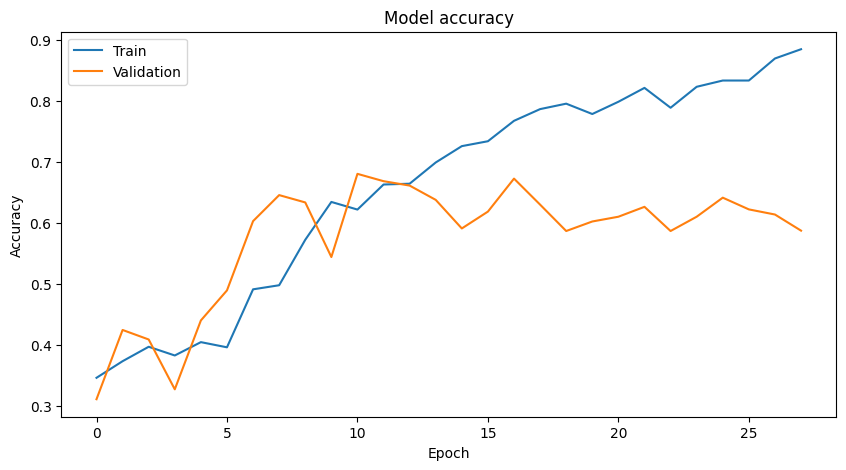

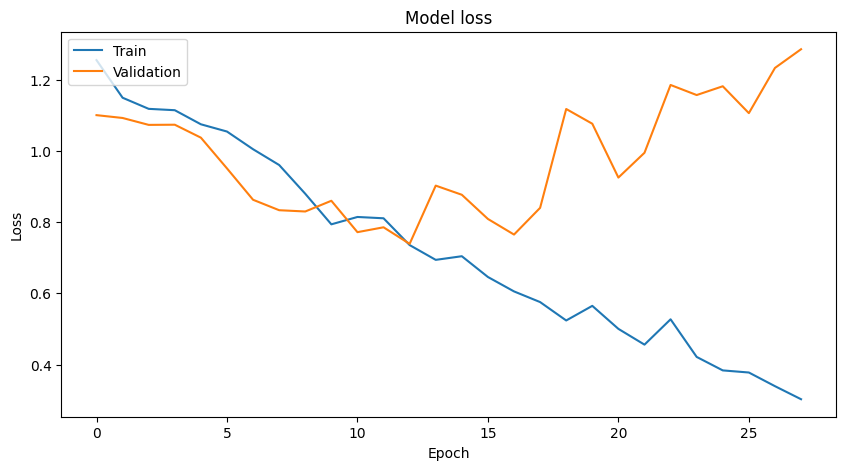

In [44]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [45]:
# Save the entire model as a `.keras` zip archive.
model.save('big_model_lung_disease_classification_transformer.keras')

In [46]:
model.save_weights("model_weights.weights.h5")

In [47]:
test = pd.read_csv("/kaggle/input/airs-ai-in-respiratory-sounds/test.csv")
print(test.info())
print(test.isnull().sum())
test

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   candidateID          338 non-null    object 
 1   age                  338 non-null    int64  
 2   gender               338 non-null    int64  
 3   tbContactHistory     338 non-null    float64
 4   wheezingHistory      338 non-null    float64
 5   phlegmCough          338 non-null    float64
 6   familyAsthmaHistory  338 non-null    float64
 7   feverHistory         338 non-null    int64  
 8   coldPresent          291 non-null    float64
 9   packYears            338 non-null    int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 26.5+ KB
None
candidateID             0
age                     0
gender                  0
tbContactHistory        0
wheezingHistory         0
phlegmCough             0
familyAsthmaHistory     0
feverHistory            0
coldPresent        

,candidateID,age,gender,tbContactHistory,wheezingHistory,phlegmCough,familyAsthmaHistory,feverHistory,coldPresent,packYears
0,136bac9a3e081,23,0,0.0,0.0,0.0,0.0,0,NaN,9
1,b121e45942a46,26,1,0.0,0.0,0.0,1.0,0,NaN,0
2,6b6853c07e4fb,26,1,1.0,0.0,0.0,0.0,1,NaN,0
3,71de185eac888,55,0,0.0,0.0,0.0,0.0,1,NaN,0
4,25deed742f133,16,0,0.0,0.0,0.0,0.0,1,NaN,0
...,...,...,...,...,...,...,...,...,...,...
333,08aac13482ff8,46,0,0.0,0.0,1.0,0.0,0,1.0,0
334,9a8601c8de4fd,54,0,0.0,0.0,1.0,0.0,0,0.0,0
335,fa284742bf6a5,57,0,0.0,0.0,1.0,0.0,0,0.0,560
336,583f6d1a089ce,22,1,0.0,0.0,1.0,0.0,1,0.0,0


In [48]:
test = test.drop(columns=["coldPresent"])
test.isnull().sum()

candidateID            0
age                    0
gender                 0
tbContactHistory       0
wheezingHistory        0
phlegmCough            0
familyAsthmaHistory    0
feverHistory           0
packYears              0
dtype: int64

In [49]:
def process_row_for_prediction(row):
    candidate_id = row["candidateID"]
    audio_path = os.path.join(SOUND_FOLDER, str(candidate_id), "cough.wav")
    mfcc = extract_mfcc(audio_path)
    features = preprocess_features(row)
    return mfcc, features  # No label for prediction

def data_generator_for_prediction(data):
    for _, row in data.iterrows():
        mfcc, features = process_row_for_prediction(row)
        yield mfcc, features

def create_prediction_dataset(data, batch_size=BATCH_SIZE):
    output_signature = (
        tf.TensorSpec(shape=(SEQ_LENGTH, N_MFCC), dtype=tf.float32),
        tf.TensorSpec(shape=(NUM_FEATURE, 1), dtype=tf.float32),
    )
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator_for_prediction(data),
        output_signature=output_signature
    )
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Example Usage
new_data_dataset = create_prediction_dataset(test, batch_size=BATCH_SIZE)

In [50]:
#new_data_dataset = new_data_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [51]:
# Recreate the model instance (architecture must match)
#model = MainModel(encoder=TransformerEncoderBlock(d_models=EMBED_DIM, num_heads=NUM_HEADS), classifier=Classifier())

# Load the saved weights
#model.load_weights("/kaggle/working/model_weights.weights.h5")

In [52]:
tf_output = model.encoder.predict(new_data_dataset)

OperatorNotAllowedInGraphError: Exception encountered when calling TransformerEncoderBlock.call().

[1mIterating over a symbolic `tf.Tensor` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may be using an unsupported feature or your source code may not be visible to AutoGraph. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#access-to-source-code for more information.[0m

Arguments received by TransformerEncoderBlock.call():
  • inputs=tf.Tensor(shape=(32, 512, 64), dtype=float32)
  • training=False